In [ ]:
import pandas_datareader.data as web
import datetime
start = datetime.datetime(2000,1,1)
end = datetime.datetime(2022,11,4)
df = web.DataReader('GOOGL','stooq',start,end)

In [ ]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2022-11-04,85.40000,86.6400,83.71000,86.58000,51124904.0
2022-11-03,86.32000,86.5200,83.34000,83.43000,61288019.0
2022-11-02,90.94000,91.1800,86.88000,86.97000,57038282.0
2022-11-01,95.45000,96.0300,90.37000,90.47000,47161351.0
2022-10-31,95.42000,96.0300,93.98000,94.51000,31675036.0
...,...,...,...,...,...
2004-08-25,2.62400,2.7000,2.59700,2.65000,183956000.0
2004-08-24,2.78100,2.7900,2.58925,2.62175,305252000.0
2004-08-23,2.76875,2.8370,2.72625,2.73500,365488000.0


In [ ]:
def Stock_Price_LSTM_Data_Precesing(df,mem_his_days, pre_days):
    df.dropna(inplace = True)
    df.sort_index(inplace = True)
    
    df['label'] = df['Close'].shift(-pre_days)
    
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    sca_X = scaler.fit_transform(df.iloc[:,:-1])
    
    from collections import deque
    deq = deque(maxlen = mem_his_days)
    
    X = []
    for i in sca_X:
        deq.append(list(i))
        if len(deq) == mem_his_days:
            X.append(list(deq))
    
    X_lately = X[-pre_days:]
    X = X[:-pre_days]
    
    y = df['label'].values[mem_his_days-1:-pre_days]
    
    import numpy as np
    X = np.array(X)
    y = np.array(y)
    return X,y,X_lately

In [ ]:
X,y,X_lately = Stock_Price_LSTM_Data_Precesing(df,5,10) 

In [ ]:
print(len(X))
print(len(y))
print(len(X_lately))

4572
4572
10


In [ ]:
pre_days = 10
# mem_days = [5,10,15]
# lstm_layers = [1,2,3]
# dense = layers = [1,2,3]
# units = [16,32]

mem_days = [5]
lstm_layers = [1]
dense_layers = [1]
units = [32]
from tensorflow.keras.callbacks import ModelCheckpoint
for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dense_layers in dense_layers:
            for the_units in units:
                filepath = './lstm_models/{val_mape: .2f}_{epoch:-2d}_'+f'mem_{the_mem_days}_flstm_{the_lstm_layers}'
                checkpoint = ModelCheckpoint(
                    filepath = filepath,
                    save_weights_only = False,
                    monitor = 'val_mape',
                    mode = 'min',
                    save_best_only = True)
                
                X,y,X_lately = Stock_Price_LSTM_Data_Precesing(df,the_mem_days,pre_days)
                from sklearn.model_selection import train_test_split
                X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle = False,test_size=0.1)
                
                import tensorflow as tf
                from tensorflow.keras.models import Sequential
                from tensorflow.keras.layers import LSTM, Dense, Dropout
                model = Sequential()
                model.add(LSTM(the_units,input_shape =X.shape[1:],activation = 'relu', return_sequences = True))
                model.add(Dropout(0.1))
                
                for i in range(the_lstm_layers):
                    model.add(LSTM(the_units, activation= 'relu'))
                    model.add(Dropout(0.1))
                    
                for i in range(the_dense_layers):
                    model.add(Dense(the_units, activation = 'relu'))
                    model.add(Dropout(0.1))
                    
                model.add(Dense(1))
                
                model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mape'])
                
                model.fit(X_train, y_train, batch_size = 32, epochs = 500,validation_data = (X_test, y_test),callbacks = checkpoint)

Epoch 1/500
128/128 [==============================] - 5s 29ms/step - loss: 577.1813 - mape: 60.9248 - val_loss: 10437.5039 - val_mape: 72.3080
Epoch 2/500
128/128 [==============================] - 3s 24ms/step - loss: 47.1107 - mape: 23.7654 - val_loss: 578.4772 - val_mape: 15.5902
Epoch 3/500
128/128 [==============================] - 3s 27ms/step - loss: 35.2511 - mape: 21.1009 - val_loss: 214.9037 - val_mape: 9.1214
Epoch 4/500
128/128 [==============================] - 0s 3ms/step - loss: 26.9698 - mape: 17.7712 - val_loss: 229.6621 - val_mape: 9.6325
Epoch 5/500
128/128 [==============================] - 3s 25ms/step - loss: 22.2109 - mape: 15.1468 - val_loss: 156.7185 - val_mape: 7.7564
Epoch 6/500
128/128 [==============================] - 3s 27ms/step - loss: 18.9494 - mape: 13.1678 - val_loss: 70.6073 - val_mape: 5.5374
Epoch 7/500
128/128 [==============================] - 0s 3ms/step - loss: 19.5570 - mape: 12.7082 - val_loss: 209.9762 - val_mape: 9.2940
Epoch 8/500
128/12

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('./lstm_models/ 4.45_111_mem_5_flstm_1')

In [ ]:
best_model.evaluate(X_test,y_test)
pre = best_model.predict(X_test)
print(len(pre))

15/15 [==============================] - 0s 2ms/step
456


In [ ]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 0s 2ms/step - loss: 203.8727 - mape: 10.2366


[203.87265014648438, 10.23658275604248]

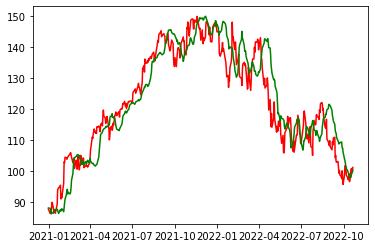

In [ ]:
import matplotlib.pyplot as plt
df_time = df.index[-len(y_test):]
plt.plot(df_time, y_test, color = 'red', label= 'price')
plt.plot(df_time, pre, color = 'green', label = 'predict')
plt.show()